In [27]:
import os
import tempfile
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers, layers, models, regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    GlobalAveragePooling1D,
    LSTM, 
    Dense, 
    Input, 
    concatenate,
    TimeDistributed,
    Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
train_dir = 'data/train'
test_dir = 'data/test'
# 비디오 파일 목록과 태그를 포함하는 리스트를 만드는 함수
def create_data_list(data_dir):
    data_list = []
    # data_dir 안의 각 디렉토리에 대해 반복
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)  # 아이템의 전체 경로
        # 해당 경로가 디렉토리인지 확인
        if os.path.isdir(item_path):
            # 디렉토리 내의 모든 파일을 나열
            for file_name in os.listdir(item_path):
                # 파일이 .mp4 파일인지 확인
                if file_name.endswith('.mp4'):
                    # 리스트에 태그와 파일 경로를 추가
                    data_list.append((item, str(data_dir+'/'+item)+'/'+file_name))
    return data_list

# 함수를 사용해서 리스트를 생성
train_list = create_data_list(train_dir)
test_list = create_data_list(test_dir)
# 리스트에서 데이터프레임을 생성
train_df = pd.DataFrame(data=train_list, columns=['tag', 'video_name'])
test_df = pd.DataFrame(data=test_list, columns=['tag', 'video_name'])
# 필요한 경우 열 순서를 수정
train_df = train_df.loc[:, ['tag', 'video_name']]
test_df = test_df.loc[:, ['tag', 'video_name']]
# 데이터프레임을 CSV 파일로 저장
train_file_path = 'train.csv'
test_file_path = 'test.csv'
train_df.to_csv(train_file_path, encoding='utf-8-sig', index=False)
test_df.to_csv(test_file_path, encoding='utf-8-sig', index=False)

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(f"Total video for training: {len(train_df)}")
print(f"Total video for testing: {len(test_df)}")

Total video for training: 50
Total video for testing: 15


In [4]:
# GPU 장치 목록 가져오기
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    # GPU의 가상 메모리 제한을 6GB로 설정
    tf.config.experimental.set_virtual_device_configuration(
        gpu_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 6)]
    )
    # set_memory_growth는 set_virtual_device_configuration과 함께 사용할 수 없습니다
else:
    print('Using CPU')

Using CPU


In [5]:
IMG_SIZE = 600
BATCH_SIZE = 64
EPOCHS = 70

MAX_SEQ_LENGTH = 30
NUM_FEATURES = 1024
SKELETON_POINTS=[x for x in range(11, 25)]
SKELETON_FEATURES = 14*4
HAND_FEATURES = 21*3*2
ARM_ANGLE_FEATURES = 2
N_CLASSES = len(np.unique(train_df["tag"]))

In [6]:
# 주어진 이미지에서 중앙에 맞춰 정사각형으로 잘나내는 함수
def crop_center_square(frame):
    # 이미지의 높이(y)와 너비(x)를 가져옴
    y, x = frame.shape[0:2]
    # 이미지의 높이와 너비 중 더 작은 값을 선택하여 정사각형의 크기를 결정
    min_dim = min(y, x)
    # 정사각형을 이미지 중앙에 위치시키기 위해 시작점의 x좌표와 y좌표를 계산
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    # 계산된 시작점과 정사각형의 크기를 이용하여 이미지의 중앙 부분을 잘라냅니다.
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [7]:
def calculate_angle(a, b, c):
    a = np.array([a.x, a.y])  # 첫 번째 점
    b = np.array([b.x, b.y])  # 중간 점 (팔꿈치)
    c = np.array([c.x, c.y])  # 세 번째 점 (손목)

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

In [8]:
# 비디오 파일을 로드하고, 각 프레임을 처리하여 배열로 반환하는 함수
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True)
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
    # OpenCV를 사용하여 비디오 파일 열기
    cap = cv2.VideoCapture(path)
    frames = []
    skeletons = []  # 스켈레톤 데이터
    hand_landmarks = []  # 손 데이터
    arm_angles = []  # 팔 각도 데이터

    try:
        while True:
            # 비디오에서 프레임을 하나씩 읽기
            ret, frame = cap.read()
            # 읽을 프레임이 없으면 반복문을 종료
            if not ret:
                break
            # 읽은 프레임에서 중앙의 정사각형 부분을 잘라냄
            frame = crop_center_square(frame)
            # 프레임의 크기를 지정된 크기로 조절
            frame = cv2.resize(frame, resize)            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Mediapipe를 사용하여 스켈레톤 추출
            hands_results = hands.process(frame_rgb)
            pose_results = pose.process(frame_rgb)
           
            if pose_results.pose_landmarks:
                right_shoulder = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
                right_elbow = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
                right_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]

                left_shoulder = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
                left_elbow = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW]
                left_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]

                right_arm_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
                left_arm_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)

                arm_angles.append((right_arm_angle, left_arm_angle))
                selected_landmarks = [pose_results.pose_landmarks.landmark[i] for i in SKELETON_POINTS]
                skeletons.append(selected_landmarks)
                for i in SKELETON_POINTS:
                    mp.solutions.drawing_utils.draw_landmarks(
                        frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                            color=(0, 255, 0), thickness=2, circle_radius=2) if i in SKELETON_POINTS else None)
                
                
            if hands_results.multi_hand_landmarks:
                hand_landmarks_data = hands_results.multi_hand_landmarks
                hand_landmarks.append(hand_landmarks_data)
                for hand_lm in hand_landmarks_data:
                    mp.solutions.drawing_utils.draw_landmarks(
                        frame, hand_lm, mp_hands.HAND_CONNECTIONS)
            
            cv2.imshow('Video Frame', frame)
            cv2.waitKey(30)
            # OpenCV는 BGR 색상 순서를 사용하므로, 이를 RGB 순서로 변경
            frame = frame[:, :, [2, 1, 0]]
            # 처리된 프레임을 프레임 리스트에 추가
            frames.append(frame)
            # max_frames가 지정된 경우, 지정된 수의 프레임만큼만 처리
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 파일을 닫기
        cv2.destroyAllWindows()
        cap.release()
        pose.close
        hands.close
    return np.array(frames), skeletons, hand_landmarks, np.array(arm_angles)

In [9]:
# 증강을 위한 함수 정의
def rotated_frame(frame):
    # 랜덤 회전을 위한 각도 설정
    angle = 45
    # 회전 변환 행렬 계산
    rotation_matrix = cv2.getRotationMatrix2D((frame.shape[1] / 2, frame.shape[0] / 2), angle, 1)
    # 프레임 회전
    rotated_frame = cv2.warpAffine(frame, rotation_matrix, (frame.shape[1], frame.shape[0]))
    return rotated_frame

In [11]:
# 증강용
def load_roatated_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    mp_hands = mp.solutions.hands
    mp_pose = mp.solutions.pose

    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True)
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
    # OpenCV를 사용하여 비디오 파일 열기
    cap = cv2.VideoCapture(path)
    frames = []
    skeletons = []  # 스켈레톤 데이터
    hand_landmarks = []  # 손 데이터
    arm_angles = []  # 팔 각도 데이터

    try:
        while True:
            # 비디오에서 프레임을 하나씩 읽기
            ret, frame = cap.read()
            # 읽을 프레임이 없으면 반복문을 종료
            if not ret:
                break
            # 읽은 프레임에서 중앙의 정사각형 부분을 잘라냄
            frame = crop_center_square(frame)
            # 프레임의 크기를 지정된 크기로 조절
            frame = cv2.resize(frame, resize)
            frame = rotated_frame(frame)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Mediapipe를 사용하여 스켈레톤 추출
            hands_results = hands.process(frame_rgb)
            pose_results = pose.process(frame_rgb)
           
            if pose_results.pose_landmarks:
                right_shoulder = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
                right_elbow = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
                right_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]

                left_shoulder = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
                left_elbow = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW]
                left_wrist = pose_results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]

                right_arm_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
                left_arm_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)

                arm_angles.append((right_arm_angle, left_arm_angle))
                selected_landmarks = [pose_results.pose_landmarks.landmark[i] for i in SKELETON_POINTS]
                skeletons.append(selected_landmarks)
                for i in SKELETON_POINTS:
                    mp.solutions.drawing_utils.draw_landmarks(
                        frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp.solutions.drawing_utils.DrawingSpec(
                            color=(0, 255, 0), thickness=2, circle_radius=2) if i in SKELETON_POINTS else None)           
                
            if hands_results.multi_hand_landmarks:
                hand_landmarks_data = hands_results.multi_hand_landmarks
                hand_landmarks.append(hand_landmarks_data)
                for hand_lm in hand_landmarks_data:
                    mp.solutions.drawing_utils.draw_landmarks(
                        frame, hand_lm, mp_hands.HAND_CONNECTIONS)
            
            cv2.imshow('Video Frame', frame)
            cv2.waitKey(30)
            # OpenCV는 BGR 색상 순서를 사용하므로, 이를 RGB 순서로 변경
            frame = frame[:, :, [2, 1, 0]]
            # 처리된 프레임을 프레임 리스트에 추가
            frames.append(frame)
            # max_frames가 지정된 경우, 지정된 수의 프레임만큼만 처리
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 파일을 닫기
        cv2.destroyAllWindows()
        cap.release()
        pose.close
        hands.close
    return np.array(frames), skeletons, hand_landmarks, np.array(arm_angles)

In [13]:
# 특징추출
def build_feature_extractor():    
    base_model = EfficientNetB7(
        weights="imagenet",
        include_top=True,
        pooling="max",
        dropout_rate=0.5,        
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.efficientnet.preprocess_input
    image_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed_image = preprocess_input(image_input)
    image_features = base_model(preprocessed_image)

    # Mediapipe 데이터 처리
    mediapipe_input = keras.Input((182,))
    mediapipe_features = keras.layers.Dense(182, activation="relu")(mediapipe_input)
    mediapipe_features = keras.layers.Dropout(0.3)(mediapipe_features)  # Dropout 추가

    # 팔 각도 데이터 처리
    arm_angle_input = keras.Input((2,))
    arm_angle_features = keras.layers.Dense(16, activation="relu")(arm_angle_input)
    arm_angle_features = keras.layers.Dropout(0.3)(arm_angle_features)  # Dropout 추가

    # 데이터 결합 및 추가 처리
    combined_features = keras.layers.concatenate(
        [image_features, mediapipe_features, arm_angle_features])
    combined_features = keras.layers.BatchNormalization()(combined_features)
    combined_features = keras.layers.Dense(
        NUM_FEATURES, activation="relu", kernel_regularizer=regularizers.l2(0.01))(combined_features)

    return keras.Model(inputs=[image_input, mediapipe_input, arm_angle_input], outputs=combined_features, name="feature_extractor")

In [ ]:
def compile_model(model, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
# 손 랜드마크를 2개로 제한한 코드
def preprocess_skeleton_data(skeleton):
    # 스켈레톤 데이터가 없는 경우 빈 벡터 반환
    if not skeleton:
        return np.zeros(SKELETON_FEATURES)
    # 스켈레톤 데이터를 1차원 배열로 변환
    skeleton_array = np.array([[lm.x, lm.y, lm.z] for lm in skeleton]).flatten()    
    # 부족한 부분을 0으로 채우기
    skeleton_array = np.pad(skeleton_array, ((0, max(0, SKELETON_FEATURES - len(skeleton_array)))))    
    return skeleton_array

def preprocess_hand_data(hand_landmarks):
    # 손 랜드마크 데이터가 없는 경우 빈 벡터 반환
    if not hand_landmarks or len(hand_landmarks) < 2:
        return np.zeros(HAND_FEATURES)
    
    # 첫 번째와 두 번째 손에 대한 랜드마크만 처리
    hand_data = []
    for hand_lm in hand_landmarks[:2]:  # 첫 번째와 두 번째 손만 처리
        lm_array = np.array([[lm.x, lm.y, lm.z] for lm in hand_lm.landmark]).flatten()
        hand_data.extend(lm_array)

    # 부족한 부분을 0으로 채우기
    hand_data = np.pad(hand_data, ((0, max(0, HAND_FEATURES - len(hand_data)))))
    return np.array(hand_data)

def preprocess_arm_angle_data(arm_angles):
    # 팔 각도 데이터가 없는 경우 빈 벡터 반환
    if not arm_angles.size == 0:
        return np.zeros(2)  # 오른팔, 왼팔 각각의 각도
    return np.array(arm_angles)

def preprocess_image(frame):
    # frame을 이미지 배열로 변환
    frame = image.img_to_array(frame)
    # EfficientNetB0에 맞는 전처리 적용
    frame = preprocess_input(frame)
    return frame

In [15]:
def prepare_all_video(df):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    # Mediapipe 데이터를 저장할 배열 초기화                          
    frame_skeletons = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, SKELETON_FEATURES), dtype="float16")
    frame_hands = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, HAND_FEATURES), dtype="float16")    
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float16")
    frame_images = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype="float16")
    frame_arm_angles = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, ARM_ANGLE_FEATURES), dtype="float16")
    
    # 특징 추출기 모델 초기화
    feature_extractor = build_feature_extractor()
    feature_extractor = compile_model(feature_extractor, learning_rate=0.001)
    
    load_list = ["load_video","load_roatated_video"]
    for load_func_name in load_list:
        load_func = globals().get(load_func_name)
        for idx, path in enumerate(video_paths):
            frames, skeletons, hands, arm_angles = load_video(path)
            video_length = min(MAX_SEQ_LENGTH, len(frames))

            for i in range(video_length):
                # 이미지 데이터 전처리 및 특징 추출
                image_feature = preprocess_image(frames[i])
                image_feature = np.expand_dims(image_feature, axis=0)

                # Mediapipe 데이터 전처리
                skeleton_feature = preprocess_skeleton_data(skeletons[i])
                hand_feature = preprocess_hand_data(hands[i])
                combined_mediapipe_data = np.concatenate([skeleton_feature, hand_feature])
                combined_mediapipe_data = np.expand_dims(combined_mediapipe_data, axis=0)

                # 팔 각도 데이터 전처리
                arm_angle_feature = preprocess_arm_angle_data(arm_angles[i])
                arm_angle_feature = np.expand_dims(arm_angle_feature, axis=0)

                # 모델 예측
                try:
                    # 특징 추출기 모델에 이미지, Mediapipe 데이터, 팔 각도 데이터 전달
                    frame_feature = feature_extractor.predict([image_feature, combined_mediapipe_data, arm_angle_feature], verbose=0)
                    frame_features[idx, i, :] = frame_feature.squeeze()  # 예측 결과 저장, .squeeze()로 불필요한 차원 제거
                except Exception as e:
                    print(f"Error during prediction at index {idx}, frame {i}: {e}")
                    # 오류 발생시 해당 프레임을 0으로 설정하거나 다른 처리를 수행
                    frame_features[idx, i, :] = np.zeros(NUM_FEATURES)
                    frame_masks[idx, i] = 0  # 오류가 발생한 프레임은 마스크에서 제외

                # 데이터 저장
                frame_images[idx, i, :] = frames[i]  # 원본 이미지 데이터 저장
                frame_skeletons[idx, i, :] = skeleton_feature
                frame_hands[idx, i, :] = hand_feature
                frame_arm_angles[idx, i, :] = arm_angle_feature
                frame_masks[idx, i] = 1
            
    # 반환 값에 Mediapipe 데이터 포함
    return (frame_features, frame_skeletons, frame_hands, frame_arm_angles, frame_masks)

In [16]:
train_data = prepare_all_video(train_df)

In [22]:
train_label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
train_labels = train_df["tag"].values
train_labels = train_label_processor(train_labels[..., None]).numpy()
train_labels = np.squeeze(train_labels)

In [ ]:
# 데이터를 파일에 저장
with open('train_data.pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [16]:
test_data = prepare_all_video(test_df)

In [17]:
test_label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(test_df["tag"]))
test_labels = test_df["tag"].values
test_labels = test_label_processor(test_labels[..., None]).numpy()
test_labels = np.squeeze(test_labels)

In [18]:
with open('test_data.pkl', 'wb') as file:
    pickle.dump(test_data, file)

In [19]:
with open('train_data.pkl', 'rb') as file:
    train_data = pickle.load(file)
with open('test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [20]:
def get_sequence_model():
    class_vocab = train_label_processor.get_vocabulary()
    
    # 입력 레이어
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    skeleton_input = keras.Input((MAX_SEQ_LENGTH, SKELETON_FEATURES))
    hand_input = keras.Input((MAX_SEQ_LENGTH, HAND_FEATURES))
    arm_angle_input = keras.Input((MAX_SEQ_LENGTH, ARM_ANGLE_FEATURES))  # 팔 각도 데이터 입력 레이어
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    
    # LSTM 레이어
    x = LSTM(32, return_sequences=True)(frame_features_input, mask=mask_input)
    x = LSTM(16, return_sequences=False)(x)  # 시퀀스의 마지막 출력만 사용    

    y_skeleton = GlobalAveragePooling1D()(skeleton_input)
    y_hand = GlobalAveragePooling1D()(hand_input)
    y_arm_angle = GlobalAveragePooling1D()(arm_angle_input)
    
    combined = concatenate([x, y_skeleton, y_hand, y_arm_angle])

    # 추가 처리 및 출력 레이어
    z = Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.01))(combined)
    output = Dense(len(class_vocab), activation="softmax", kernel_regularizer=regularizers.l2(0.01))(z)
    
    # 모델 생성 및 컴파일
    lstm_model = keras.Model([frame_features_input, skeleton_input, hand_input, arm_angle_input, mask_input], output)
    lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return lstm_model

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 1.9411 - accuracy: 0.2857
Epoch 1: val_loss improved from inf to 2.42568, saving model to tmp\video_classifier_lstm.h5
1/1 [==============================] - 12s 12s/step - loss: 1.9411 - accuracy: 0.2857 - val_loss: 2.4257 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 1.9091 - accuracy: 0.2857
Epoch 2: val_loss did not improve from 2.42568
1/1 [==============================] - 0s 40ms/step - loss: 1.9091 - accuracy: 0.2857 - val_loss: 2.4835 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 1.8804 - accuracy: 0.2857
Epoch 3: val_loss did not improve from 2.42568
1/1 [==============================] - 0s 41ms/step - loss: 1.8804 - accuracy: 0.2857 - val_loss: 2.5356 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 1.8583 - accuracy: 0.2857
Epoch 

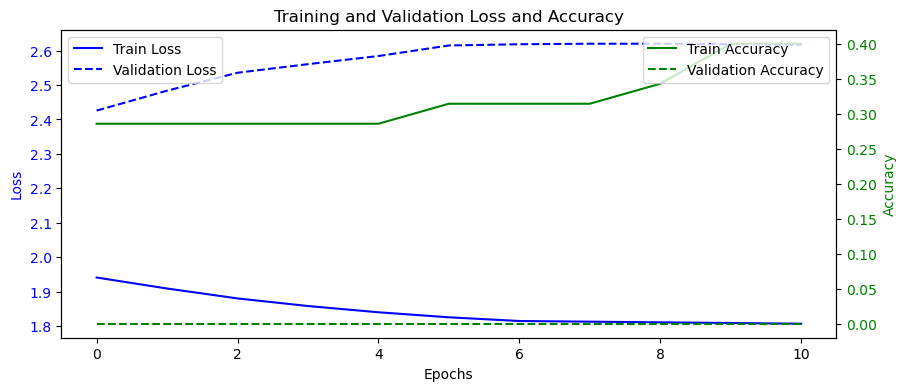

In [28]:
EPOCHS = 200
BATCH_SIZE= 64
def run_experiment():
    filepath = "tmp/video_classifier_lstm.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1)

    seq_model = get_sequence_model()
    
    # 조기 종료 및 학습률 감소 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)    
    
    # 모델 학습
    history = seq_model.fit(
        [train_data[0], train_data[1], train_data[2], train_data[3], train_data[4]],
        train_labels,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping, reduce_lr],
    )

    seq_model.load_weights(filepath)
    
    # 테스트 데이터에 대한 평가
    _, accuracy = seq_model.evaluate(
        [test_data[0], test_data[1], test_data[2], test_data[3], test_data[4]],
        test_labels
    )
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
    # 손실 및 정확도 그래프 출력
    plt.figure(figsize=(10, 4))
    # 손실 그래프
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(history.history['loss'], label='Train Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
    ax1.set_title('Training and Validation Loss and Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')
    # 정확도 그래프를 같은 그래프에 추가
    ax2 = ax1.twinx()
    ax2.plot(history.history['accuracy'], label='Train Accuracy', color='green')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='dashed')
    ax2.set_ylabel('Accuracy', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.show()
    
    seq_model.save('lstm_model.h5')
    
    return history, seq_model

_, sequence_model = run_experiment()

In [24]:
def prepare_single_video(frames, skeletons, hands, arm_angles):
    num_frames = len(frames)
    video_length = min(MAX_SEQ_LENGTH, num_frames)

    # 데이터 초기화
    frame_mask = np.zeros((1, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros((1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float16")
    frame_skeletons = np.zeros((1, MAX_SEQ_LENGTH, SKELETON_FEATURES), dtype="float16")
    frame_hands = np.zeros((1, MAX_SEQ_LENGTH, HAND_FEATURES), dtype="float16")
    frame_arm_angles = np.zeros((1, MAX_SEQ_LENGTH, ARM_ANGLE_FEATURES), dtype="float16")
        
    feature_extractor = Sequential([
        EfficientNetB7(weights="imagenet",
        include_top=True,
        pooling="max",
        dropout_rate=0.5, ),
        Dense(NUM_FEATURES, activation='relu')
    ])
    
    for j in range(video_length):
        # 이미지 데이터 전처리 및 특징 추출
        image_feature = preprocess_image(frames[j])
        image_feature = np.expand_dims(image_feature, axis=0)
        feature_result = feature_extractor.predict(image_feature)

        # 특징 저장
        frame_features[0, j] = feature_result

        # Mediapipe 데이터 전처리
        skeleton_feature = preprocess_skeleton_data(skeletons[j])
        hand_feature = preprocess_hand_data(hands[j])        
        arm_angle_feature = np.array(arm_angles[j])

        # 데이터 저장
        frame_skeletons[0, j] = skeleton_feature
        frame_hands[0, j] = hand_feature
        frame_mask[0, j] = 1        
        frame_arm_angles[0, j] = arm_angle_feature

    return frame_features, frame_skeletons, frame_hands, frame_mask, frame_arm_angles

In [25]:
def sequence_prediction(path, sequence_model):
    class_vocab = test_label_processor.get_vocabulary()
    frames, skeletons, hands, arm_angles = load_video(path)    
    try:
        num_frames = len(frames)
    except IndexError:
        print("Error: Unable to determine the number of frames. Frames shape:", frames.shape)
        return None
    
    # EfficientNetB0 모델을 사용하여 프레임에서 특징 추출
    frame_features, frame_skeletons, frame_hands, frame_mask, frame_arm_angles = prepare_single_video(frames, skeletons, hands, arm_angles)
    
    # LSTM 모델을 사용하여 예측 수행
    probabilities = sequence_model.predict([frame_features, frame_skeletons, frame_hands, frame_arm_angles, frame_mask])[0]
    
    # 가장 가능성 높은 레이블 출력
    for i in np.argsort(probabilities)[::-1]:
        print(f"{class_vocab[i]} : {probabilities[i] * 100:5.2f}%")
    
    return frames

In [26]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video,sequence_model)

Test video path: data/test/NIA_SL_SEN0013/NIA_SL_SEN0013_REAL14_F.mp4
1/1 [==============================] - 3s 3s/step
NIA_SL_SEN0275 : 100.00%
NIA_SL_SEN0203 :  0.00%
NIA_SL_SEN0013 :  0.00%
NIA_SL_SEN0011 :  0.00%
NIA_SL_SEN0159 :  0.00%
